# Kalman filter for Particule Tracing

## 1. Linear Model, deterministic process, unkown initialisation

We consider the following setup:

Underlying Physics
- State $\textbf{x} = \begin{pmatrix}
x & y & v_x & v_y
\end{pmatrix} \in R^4$
- With charge $q$
- In electric field / gravity field $\vec{E}$
- Is subject to accelation (force) $q\vec{E}$
- In time $dt$ it moves as 
$\textbf{x}(t+dt)=\begin{equation}
  \begin{cases}
      x & = x+dtv_x\\
      y & = y +dtv_y\\
      v_x & = v_x+qdtE_x(x,y)\\
      v_y & = v_x+qdtE_y(x,y)\\
    \end{cases}       
\end{equation}$

Linearity assumption
- The electric field is linear in the position $E(x,y) = G\begin{pmatrix}
x\\ y
\end{pmatrix}$ with $G\in R^{2\times 2}$

Dynamical System Model (deterministic)

- Initialisation $x_0\in R^4$
- Transition $x_{t} = Fx_{t-1}$
- Transition matrix $F = \begin{pmatrix}
I_{2\times 2} & dt I_{2\times2}\\
qdtG & I_{2\times2}
\end{pmatrix}$

Observation Model (GPS only: noisy position)

$y_t = Hx_t+ v_t$

- new observation $y_t$
- obervation model $H = \begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{pmatrix}$
- observation noise $w_t \sim \mathcal{N}(0,R)$ (with $R = \sigma_{obs}I_{2\times2}$)

Note: 
- Observe that the process is deterministic (it only depends on $\mathbf{x}_0$)
- For the moment, we assume we have no prior on $\mathbf{x}_0$ so we are in a non-bayesian setup

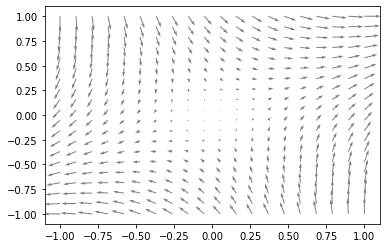

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## STATE VARIABLES

T = 20
dt = 0.01
q = 100
mes_noise = 0.1
R = (mes_noise**2)*np.identity(2) #measurement noise

## TRANSITION MATRIX 

F = np.array([
        [1,0,dt,0],
        [0,1,0,dt],
        [q*dt,q*dt,1,0],
        [q*dt,-q*dt,0,1]
    ])

## MEASURE MODEL

H = np.array([[1,0,0,0],[0,1,0,0]])

## PLOTTING

def plot_field(F):
    A,B = np.meshgrid(np.linspace(-1,1,20),np.linspace(-1,1,20))
    G = F[2:,:2]
    u,v = np.tensordot(G,np.array([A,B]), axes = ([0],[0]))
    #u,v = f(A,B)
    plt.quiver(A,B,u,v, color = "grey")
    
plot_field(F)

In [24]:
## REAL TRAJECTORY

def trajectory(x_0,T):
    """
    X0: initial state
    T: number of timesteps
    """
    return np.array([np.linalg.matrix_power(F,i).dot(x_0) for i in range(T)])

x_0 = np.array([-0.5,0.5,0,0])
X = trajectory(x_0,T)

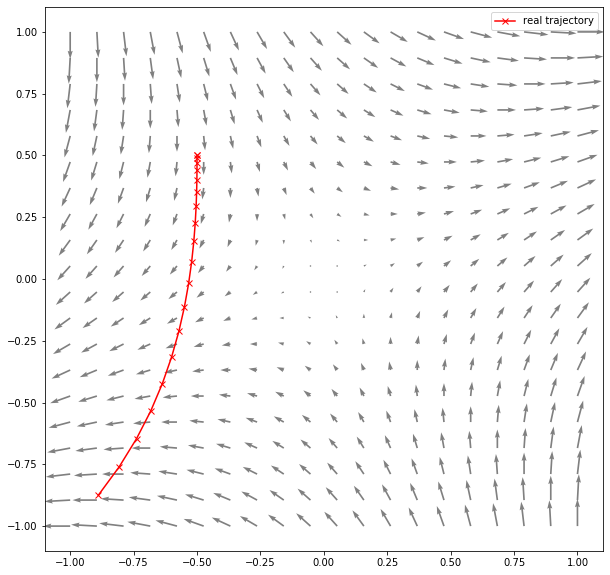

In [25]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="real trajectory")
plot_field(F)
plt.legend()
plt.show()

In [26]:
## OBSERVATION MODEL

def observation(X,R):
    Z = [H.dot(x)+ np.random.multivariate_normal(mean = np.zeros(2),cov=R) for x in X]
    return np.array(Z)

Y = observation(X,R)

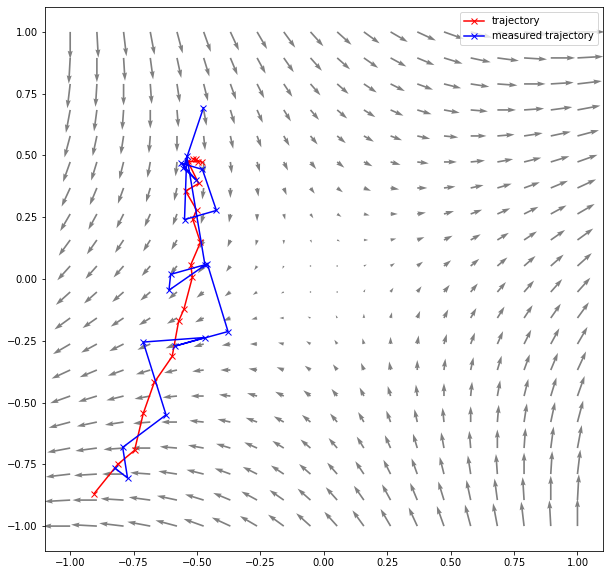

In [41]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.plot(Y[:,0],Y[:,1], color ="blue",marker="x",label="measured trajectory")
plot_field(F)
plt.legend()
plt.show()

### 1.1 Running Average Filter "Alpha Beta filter"

Assuming no knowledge of the starting speed, we can attempt to reduce the measurement noise by avaraging the new measurement with most recent estimation

- alpha: regularization factor (belief that previous mesurement is still valid)
- beta: belief in new measurement

In [28]:
## Alpha Beta FILTER 
alpha = 0.5
beta = 0.5

#initialisation
X_alpha_beta = np.zeros((T,2))
X_alpha_beta[0] = Y[0]

#update
for t in range(1,T):
    X_alpha_beta[t] = alpha*X_alpha_beta[t-1]+beta*Y[t]

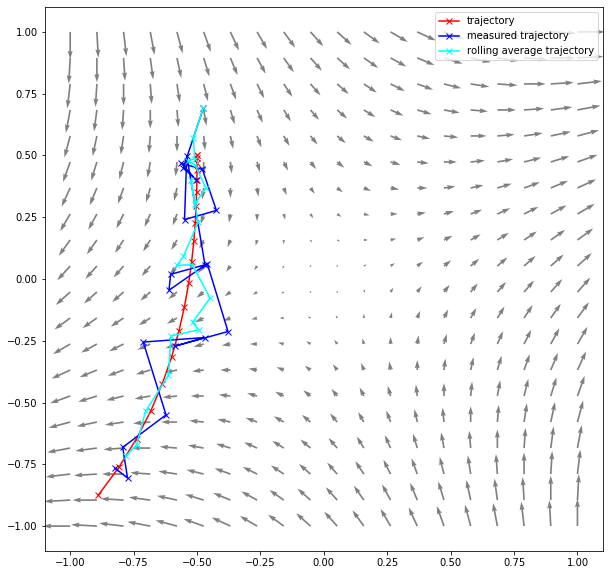

In [29]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.plot(Y[:,0],Y[:,1], color ="blue",marker="x",label="measured trajectory")
plt.plot(X_alpha_beta[:,0],X_alpha_beta[:,1], color ="cyan",marker="x",label="rolling average trajectory")
plot_field(F)
plt.legend()
plt.show()

## 1.2 MLE Filter

Recall that there is no process noise. 

The sequence $(x_i)_{i\leq T} = (F^ix_0)_{i\leq T}$ is therefore deterministic

Therefore, we observe positions $(y_i)_{i\leq T} = (HF^ix_0)_{i\leq T}$ follows distribution $\mathcal{N}\left(
\begin{pmatrix}
Hx_0\\
HFx_0\\
...\\
HF^Tx_0
\end{pmatrix},
\begin{pmatrix}
R,0,...\\
0,R,...\\
0,0,...\\
...,0,R\end{pmatrix}
\right)$

Finding $x_0$ (and therefore estimating the trajectory) becomes a maximum likelihood problem, and we have

$$x_0^{MLE} = \text{argmin}_{x\in R^4}||Ax-b||_2^2$$

where $A = \begin{pmatrix}
Hx_0\\
HFx_0\\
...\\
HF^Tx_0
\end{pmatrix}$
and $b = \begin{pmatrix}
y_0\\
y_1\\
...\\
y_T
\end{pmatrix}$

Note: 
- This will be done in a naive way (expliciting $A$) in the code below. Therefore it is not scalable with time (whereas the whole point of the Kalman filter is that computation time does not depend on current $t$)
- $x_i^{MLE} = A^ix_0^{MLE}$ so it really all boils down to estimating $x_0\in R^4$

In [30]:
k=20
X_MLE = []
for k in range(1,T+1):
    M = np.array([H.dot(np.linalg.matrix_power(F,i)) for i in range(k)])
    A = np.concatenate(M, axis=0)
    b = np.concatenate(Y[:k])
    x, residuals, rank, s = np.linalg.lstsq(A,b)
    X_MLE.append(H.dot(np.linalg.matrix_power(F,k-1)).dot(x))

X_MLE = np.array(X_MLE)

C:\Users\romai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


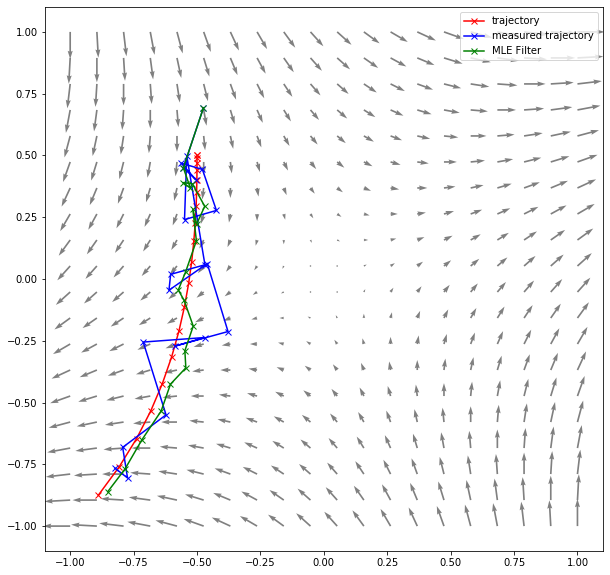

In [32]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.plot(Y[:,0],Y[:,1], color ="blue",marker="x",label="measured trajectory")
plt.plot(X_MLE[:,0],X_MLE[:,1], color ="green",marker="x",label="MLE Filter")
plot_field(F)
plt.legend()
plt.show()

## 1.3 Kalman Filter (mini)

We implement the update rules that can be found here : https://en.wikipedia.org/wiki/Kalman_filter

Estimation Model
- prior estimated state $\hat{x}_{t|t-1}$
- prior estimated covariance $\hat{P}_{t|t-1}$
- posterior estimated state $\hat{x}_{t|t}$
- posterior estimated covariance $\hat{P}_{t|t}$

Prediction Rules
- a priori state estimation $\hat{x}_{t|t-1} = F\hat{x}_{t-1|t-1}$
- a priori covariance estimation $\hat{P}_{t|t-1} = F_{t-1}P_{t-1|t-1}F_{t-1}^T+Q$

Innovation Rules
- innovation estimation $i_t = z_t-H\hat{x}_{t|t-1}$
- innovation covariance $S_t = HP_{t|t-1}H^T+R$
- optimal Kalman gain $K_t = P_{t|t-1}H^TS_t^{-1}$
- a posteriori state estimation $\hat{x}_{t|t} = \hat{x}_{t|t-1}+K_ti_t$
- a posteriori covariance estimation $P_{t|t} = (I-K_tH)P_{t|t-1}$

Note:
- To account for the fact that we have no initial knowledge of the speed, we give a very large variance to the initial speed estimate (like $1e10$)
- It is reassuring to observe that, under these conditions, the Kalman filter has the exact same behavior as the "MLE filter"

In [33]:
## Extended Kalman Filter

def extended_kalman_filter(x_h_prev,P_prev,y):
    """
    INPUTS:
        x_h_prev: previous estimate of state
        P_prev: previous covariance matrix
        y: new measurement
    
    OUTPUT: 
        x_h_posteriori: next estimate of the state
        P_posteriori: covariance estimate matrix    
    """    
    x_h_priori = F.dot(x_h_prev) #a priori state estimation
    P_priori = F.dot(P_prev).dot(F.T)
    i = y-H.dot(x_h_priori) #innovation
    S = H.dot(P_priori).dot(H.T)+R #innovation covariance
    K = P_priori.dot(H.T).dot(np.linalg.inv(S)) #optimal Kalman gain
    x_h_posteriori = x_h_priori + K.dot(i)
    P_posteriori = (np.identity(4)-K.dot(H)).dot(P_priori)
    return x_h_posteriori,P_posteriori

#Initialisation of estimates
X_h0 = np.zeros(4)
X_h0[:2] = Y[0]
P0 = (mes_noise**2)*np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1e10,0],
    [0,0,0,1e10]
])
X_kalman = [X_h0]
P_kalman = [P0]

# Computation online
for t in range(1,T):
    res = extended_kalman_filter(X_kalman[-1],P_kalman[-1],Y[t])
    X_kalman.append(res[0])
    P_kalman.append(res[1])
X_kalman = np.array(X_kalman)

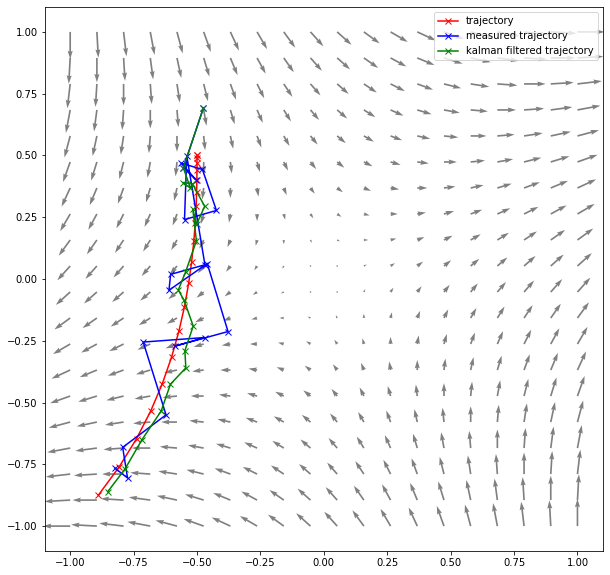

In [34]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.plot(Y[:,0],Y[:,1], color ="blue",marker="x",label="measured trajectory")
plt.plot(X_kalman[:,0],X_kalman[:,1], color ="green",marker="x",label="kalman filtered trajectory")
plot_field(F)
plt.legend()
plt.show()

## 1.4 Comparison

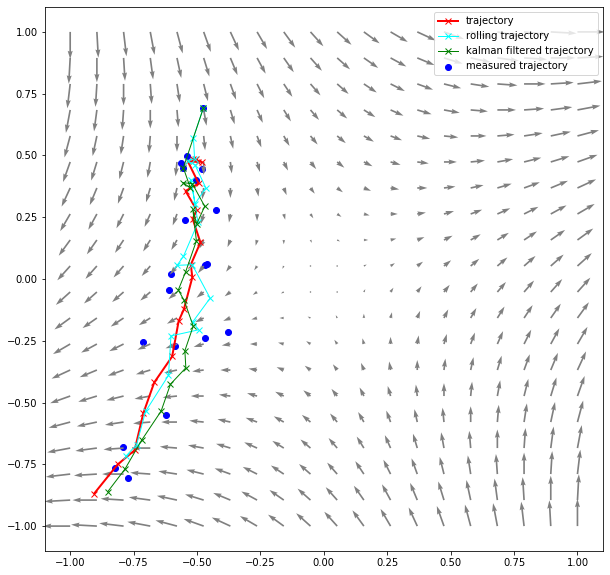

In [51]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory", linewidth=2)#linestyle ="dashed",
plt.scatter(Y[:,0],Y[:,1], color ="blue",marker="o",label="measured trajectory")
plt.plot(X_alpha_beta[:,0],X_alpha_beta[:,1], color ="cyan",marker="x",label="rolling trajectory", linewidth=1)
plt.plot(X_kalman[:,0],X_kalman[:,1], color ="green",marker="x",label="kalman filtered trajectory", linewidth=1)
plot_field(F)
plt.legend()
plt.show()

In [36]:
def mse(Z):
    return np.mean((X[:,:2]-Z)**2)

pd.DataFrame({"Estimation Strategy":["Noisy","Rolling","MLE","Kalman"], "MSE":[mse(Y), mse(X_alpha_beta),mse(X_MLE),mse(X_kalman[:,:2])]})

,Estimation Strategy,MSE
0,Noisy,0.009077
1,Rolling,0.006062
2,MLE,0.004198
3,Kalman,0.004198


## 1.2 Linear Model, noisy process, unkown initialisation

We introduce process noise $v_t\sim \mathcal{N}(0,Q)$
- Transition $x_{t} = Fx_{t-1}+v_t$

This can be justified by the fact that there are irregularities in the magnetic field

Note:
- Somehow dt should appear in $Q$ (like for a brownian motion). We leave that for later. 

In [37]:
# New parameters
process_noise = 0.02
Q = (process_noise)**2*np.identity(4)

In [38]:
def trajectory(x_0,T):
    """
    X0: initial state
    T: number of timesteps
    """
    return np.array([np.linalg.matrix_power(F,i).dot(x_0)+np.random.multivariate_normal(mean = np.zeros(4),cov=Q) for i in range(T)])

x_0 = np.array([-0.5,0.5,0,0])
X = trajectory(x_0,T)

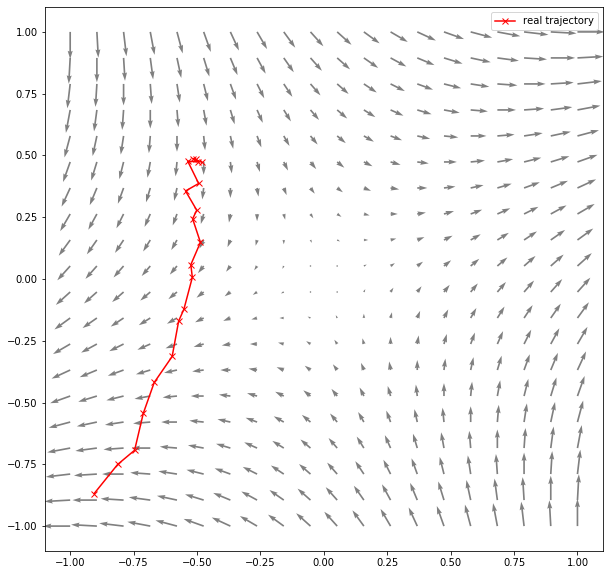

In [39]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="real trajectory")
plot_field(F)
plt.legend()
plt.show()

In [17]:
def observation(X,R):
    Z = [H.dot(x)+ np.random.multivariate_normal(mean = np.zeros(2),cov=R) for x in X]
    return np.array(Z)

Y = observation(X,R)

In [18]:
## Alpha Beta FILTER 
alpha = 0.5
beta = 0.5

#initialisation
X_alpha_beta = np.zeros((T,2))
X_alpha_beta[0] = Y[0]

#update
for t in range(1,T):
    X_alpha_beta[t] = alpha*X_alpha_beta[t-1]+beta*Y[t]

In [19]:
#MLE filter
k=20
X_MLE = []
for k in range(1,T+1):
    M = np.array([H.dot(np.linalg.matrix_power(F,i)) for i in range(k)])
    A = np.concatenate(M, axis=0)
    b = np.concatenate(Y[:k])
    x, residuals, rank, s = np.linalg.lstsq(A,b)
    X_MLE.append(H.dot(np.linalg.matrix_power(F,k-1)).dot(x))

X_MLE = np.array(X_MLE)

C:\Users\romai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [20]:
## Extended Kalman Filter
def extended_kalman_filter(x_h_prev,P_prev,y):
    """
    INPUTS:
        x_h_prev: previous estimate of state
        P_prev: previous covariance matrix
        y: new measurement
    
    OUTPUT: 
        x_h_posteriori: next estimate of the state
        P_posteriori: covariance estimate matrix    
    """    
    x_h_priori = F.dot(x_h_prev) #a priori state estimation
    P_priori = F.dot(P_prev).dot(F.T)+Q# a priori covariance estimation
    i = y-H.dot(x_h_priori) #innovation
    S = H.dot(P_priori).dot(H.T)+R #innovation covariance
    K = P_priori.dot(H.T).dot(np.linalg.inv(S)) #optimal Kalman gain
    x_h_posteriori = x_h_priori + K.dot(i)
    P_posteriori = (np.identity(4)-K.dot(H)).dot(P_priori)
    return x_h_posteriori,P_posteriori

#Initialisation of estimates
X_h0 = np.zeros(4)
X_h0[:2] = Y[0]
P0 = (mes_noise**2)*np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1e10,0],
    [0,0,0,1e10]
])
X_kalman = [X_h0]
P_kalman = [P0]

# Computation online
for t in range(1,T):
    res = extended_kalman_filter(X_kalman[-1],P_kalman[-1],Y[t])
    X_kalman.append(res[0])
    P_kalman.append(res[1])
X_kalman = np.array(X_kalman)

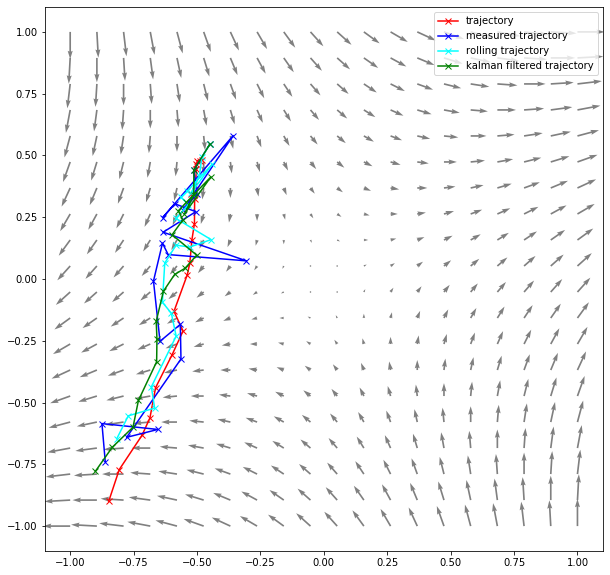

In [21]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.plot(Y[:,0],Y[:,1], color ="blue",marker="x",label="measured trajectory")
plt.plot(X_alpha_beta[:,0],X_alpha_beta[:,1], color ="cyan",marker="x",label="rolling trajectory")
plt.plot(X_kalman[:,0],X_kalman[:,1], color ="green",marker="x",label="kalman filtered trajectory")
plot_field(F)
plt.legend()
plt.show()

In [22]:
def mse(Z):
    return np.mean((X[:,:2]-Z)**2)

pd.DataFrame({"Estimation Strategy":["Noisy","Rolling","MLE","Kalman"], "MSE":[mse(Y), mse(X_alpha_beta),mse(X_MLE),mse(X_kalman[:,:2])]})

,Estimation Strategy,MSE
0,Noisy,0.010176
1,Rolling,0.008695
2,MLE,0.004855
3,Kalman,0.004809
